# Mini Batch K-Means and Spectral Clustering on Medium or Large dataset

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import RegexpTokenizer, WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from string import punctuation
import collections
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import en_core_web_sm

from tqdm import tqdm
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score

# Loading the dataset

One of the first operations performed on the dataset is to drop any possible duplicates in the tweets row. I observed that dropping duplicates improved performance while keeping the overall metrics largely the same. The dataset can be changed to 'large' by changing the value for the variable 'inp'. I have currently kept it at 'medium' for smooth functioning of the program. Changing it to 'large' will cause the notebook to take nearly 2 hours to run completely. The results on the medium dataset and the large dataset were somewhat comparable for all three algorithms. However, some issues related to memory might crop up if you run k-means or spectral clustering on the large dataset without SVD. Using Google Colab can remedy this problem in certain cases.

In [95]:
inp = "medium"

if inp == "large":
    tweets_df = pd.read_csv('Challenge1_Large.csv')
    np.random.seed(18)
    remove_n = 120000
    drop_indices = np.random.choice(tweets_df.index, remove_n, replace=False)
    tweets_df = tweets_df.drop(drop_indices)

else:
    tweets_df = pd.read_csv('Challenge1_Medium.csv')

tweets_df = tweets_df.drop_duplicates(subset=['text'])


text = tweets_df.text.to_list()
len(text)

8611

# Stage 1 Cleaning

This involves removal of certain elements that are peculiar to this particular dataset. For instance, links starting with 'https' and strings such as 'RT @' are removed. Most UTF-8 encoded special characters can also be removed. Apostrophes are retained for demonstration purposes. These will be eliminated in the punctuation elimination section.

In [96]:
def clean_text(text):
    pattern = re.compile(r'\\[a-z0-9]{3}\\[a-z0-9]{3}\\[a-z0-9]{3}')
    pattern2 = re.compile(r'\"b\'')
    req_list = []
    for ele in text:
        ele = str(ele)
        if "\\xe2\\x80\\x99" in ele:
            req_string = re.sub(re.compile(r"\\xe2\\x80\\x99"), "\'", ele)
        else:
            req_string = ele    
        
        req_string = req_string.replace("RT @", "").replace("https", "")
        req_string = re.sub(pattern, "", req_string)
        req_string = re.sub(re.compile(r'\\n'), "", req_string)
        req_string = req_string.replace('"','').replace('b\'',"")
        req_list.append(req_string)
    return req_list

# Text Pre-processing Helper Function

Reference for text pre-processing : https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

We define a preprocessing function that involves several steps. The first step is to remove any punctuations. This includes commas, full-stops, etc. We then tokenize the tweets. This means that each tweet is converted into a list of words. This is done using the Python regex module. The NLTK package maintains a standard corpus of English stopwords. These are inconsequential words that interfere with a detailed analysis fo the data. 

Finally, we perform stemming and lemmatization. Both of these operations cut down the length of the word. A term such as 'walking' is simply cut down to 'walk'. Lemmatization is slightly more computationally expensive. We first perform stemming and run the dataset through a lemmetizer later to reduce computational time. These operations result in a smaller feature vector. Words such as 'write', 'writing', and 'written' all get condensed to 'write', thus making it easier to process. 

In [97]:
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Ref: https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

def preprocess(df, col, new_col):
    def remove_punctuation(text):
        return "".join([k for k in text if k not in string.punctuation])
        
        #storing the puntuation free text
    df[new_col]= df[col].apply(lambda x:remove_punctuation(x))
    df[new_col]= df[new_col].apply(lambda x: x.lower())

    def tokenization(text):
        return re.split('W+',text)
    #applying function to the column
    df[new_col]= df[new_col].apply(lambda x: tokenization(x))

    stopwords = nltk.corpus.stopwords.words('english')
    def remove_stopwords(text):
        return [k for k in text if k not in stopwords]

    df[new_col]= df[new_col].apply(lambda x:remove_stopwords(x))

    porter_stemmer = PorterStemmer()

    def stemming(text):
        return [porter_stemmer.stem(word) for word in text]

    df[new_col] = df[new_col].apply(lambda x: stemming(x))

    wordnet_lemmatizer = WordNetLemmatizer()
    def lemmatizer(text):
        return [wordnet_lemmatizer.lemmatize(word) for word in text]
    df[new_col]=df[new_col].apply(lambda x:lemmatizer(x))



    count = 0
    for i, row in df.iterrows():
        if(len(row[new_col]) == 0):
            df.iloc[i][new_col] = [" "]

    flattened  = [val for sublist in df[new_col].to_list() for val in sublist]
    df[new_col] = flattened
    
    return df

# Function for choosing clusters using silhouette scores

Source : https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html (Official Sklearn documentation)


This function is heavily inspired by the Scikit learn example for silhouette scores. Since we do not have reliable labels, silhouette scores can be powerful tools in identifying the ideal number of clusters. We can also use elbow diagrams for this purpose. However, Silhouette scores give us good plots and visualizations in two dimensions. We can use these plots to also see the effectiveness of the clustering algorithm. 

We begin by initializing the clustering algorithm with n_clusters and a random state. We then plot each of the silhouettes with their corresponding 2D plot of feature 1 vs. feature 2. Although SVD is not a part of the mini-batch K-means algorithm, we use it in this function just for visualization purposes.

The silhouette score can lie between -1 and 1. If the score is closer to 1, it means that the clusters are more distinct from each other. We use len(x) + (n_clusters + y)*x to insert more blank space between each of the silhouette plots. This is also inspired from the Scikit Learn example. We then sort the cluster silhouette scores within a for loop and plot them.

In [148]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD

def plot_silhouette(tweets_df_mod):

    vec = TfidfVectorizer(stop_words="english")
    col = "preprocessed_tweet"
    vec.fit(tweets_df_mod[col].values)

    pca = TruncatedSVD(n_components=2)

    features  = vec.transform(tweets_df_mod[col].values)
    features  = pca.fit_transform(features )

    range_n_clusters = [3, 4, 5, 6, 7, 8, 9]
    for n_clusters in tqdm(range_n_clusters):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(features ) + (n_clusters + 1) * 8])

        res = MiniBatchKMeans(n_clusters=n_clusters, random_state=10)
        kmeans_labels = res.fit_predict(features )

        silhouette_avg = silhouette_score(features , kmeans_labels)
        print("Number of clusters =", n_clusters,
              "Average silhouette score is found to be :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(features , kmeans_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[kmeans_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.8)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("Silhouette plot")
        ax1.set_xlabel("Silhouette coefficient")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="blue", linestyle="--")

        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        colors = cm.nipy_spectral(kmeans_labels.astype(float) / n_clusters)
        ax2.scatter(features [:, 0], features [:, 1], marker='.', s=40, lw=0, alpha=0.8,
                    c=colors, edgecolor='r')

        # Labeling the clusters
        centers = res.cluster_centers_

        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="yellow", alpha=1, s=180, edgecolor='r')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("Distribution of clustered data")
        ax2.set_xlabel("Feature - 1 space")
        ax2.set_ylabel("Feature - 2 space")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = " + str(n_clusters)))

    plt.show()

# Metrics to evaluate clustering

The following function is used to print all the defining metrics for the clustering exercise. We use four metrics:

<b>Homogeneity:</b> 

- Measure of co-occurrence of target labels and clustering labels 
- homogeneity_score([0, 1, 0, 1], [1, 0, 1, 0]) = 1 since all 0's are assigned to 1's and 1's are assigned to 0's


<b>Completeness:</b>

- Similar to homogeneity score, but is sensitive to the order in which the parameters are passed.


<b>V-measure:</b> 

- The harmonic mean of the homogeneity and completeness. It is given by: (1 + beta) * homogeneity * completeness / (beta * homogeneity +   completeness)

<b>Adjusted Rand-Index:</b>

- The Rand Index is given by the ratio: (TP + TN) / (TP + TN + FP + FN), where TP = True Positive, TN = True Negative, FP = False Positive, and FN = False Negative
- The adjusted Rand Index adjusts for the expected value. Therefore, it can range from -1 to +1. A low adj. Rand Index indicates that there are fewer correct labels than expected.


In [100]:
def calc_metrics(cr_df, col = 'kmeans_labels_tweets', col2 = '2017 Pew Research Typology'):
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(cr_df[col].to_list(), cr_df[col2].to_list()))
    print("Completeness: %0.3f" % metrics.completeness_score(cr_df[col].to_list(), cr_df[col2].to_list()))
    print("V-measure: %0.3f" % metrics.v_measure_score(cr_df[col].to_list(), cr_df[col2].to_list()))
    print("Adjusted Rand-Index: %.3f"
        % metrics.adjusted_rand_score(cr_df[col].to_list(), cr_df[col2].to_list()))

Run the preprocessing steps on the tweets dataset. 'nltk.download' can be used to download these word sets in case it is not already available. We need to perform an index reset at the end of all the filtering and preprocessing operations. We visualize the dataset at the end of the pre-processing step.

In [98]:
nltk.download('stopwords')
nltk.download('wordnet')
tweets_df_mod = tweets_df.copy()
print(len(tweets_df_mod))
tweets_df_mod = tweets_df_mod.drop(columns = ['Unnamed: 0', 'created_at', 'id', 'reply_to_id', 'screen_name',
       'coordinates', 'place', 'retweet_count', 'favorite_count', 'lang',
       'source', 'is_quote_status', 'user_id', 'user_loc',
       'verified', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'user_created_at'])

tweets_df_mod['tweet_filtered'] = clean_text(tweets_df.text.to_list())
tweets_df_mod['description_filtered'] = clean_text(tweets_df_mod.user_description.to_list())
tweets_df_mod = tweets_df_mod.drop(columns=['user_description', 'text'])
tweets_df_mod.reset_index(drop=True, inplace=True)
tweets_df_mod = preprocess(tweets_df_mod, 'tweet_filtered', 'preprocessed_tweet')
tweets_df_mod = preprocess(tweets_df_mod, 'description_filtered', 'preprocessed_description')

tweets_df_mod

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nsbha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nsbha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


8611


tweet_filtered  \
0     PramilaJayapal: We've seen this movie before.R...   
1     GarrettHaake: Just wrapped an interview w/ @Se...   
2     ezralevin: Spoiler alert: you're never getting...   
3     JamaalBowmanNY: If what I'm reading is true, I...   
4     PalmerReport: To be clear, once the republican...   
...                                                 ...   
8606  I am hope that this spending bill will be cutt...   
8607  b@JordanChariton @JoeBiden He doesn't want an ...   
8608  @SMcCallum93 @Mick241602 @pritipatel You plain...   
8609  @NGrossman81 He wants an infrastructure bill, ...   
8610  Guess who was on top of the infrastructure Bil...   

                                   description_filtered  \
0     English Teacher to the Stars (well... sort of....   
1     My husband and I are retired and enjoy spendin...   
2     #Chiefs_Champs  #JJJHawk  #ForeverRoyalLiberal...   
3     b(he/him/his) Dad/Archivist with opinions on m...   
4                                           Being me x'   
...                                                 ...   
8606  The real business person of all businesses, no...   
8607                              Opinions are my own.'   
8608  British Jew. Woman. Artist. Mother. Zionist. A...   
8609  One hard-nosed political commentator. Words in...   
8610  bGM skilled retiree/Natural Health-UAW strong-...   

                                     preprocessed_tweet  \
0     pramilajayapal weve seen this movie beforerepu...   
1     garretthaake just wrapped an interview w senjo...   
2     ezralevin spoiler alert youre never getting 10...   
3     jamaalbowmanny if what im reading is true i wo...   
4     palmerreport to be clear once the republicans ...   
...                                                 ...   
8606  i am hope that this spending bill will be cutt...   
8607  bjordanchariton joebiden he doesnt want an inf...   
8608  smccallum93 mick241602 pritipatel you plainly ...   
8609  ngrossman81 he wants an infrastructure bill so no   
8610  guess who was on top of the infrastructure bil...   

                               preprocessed_description  
0     english teacher to the stars well sort of publ...  
1     my husband and i are retired and enjoy spendin...  
2     chiefschamps  jjjhawk  foreverroyalliberal ath...  
3     bhehimhis dadarchivist with opinions on many t...  
4                                            being me x  
...                                                 ...  
8606  the real business person of all businesses nob...  
8607                                opinions are my own  
8608  british jew woman artist mother zionist a drea...  
8609  one hardnosed political commentator words in a...  
8610  bgm skilled retireenatural healthuaw strongcat...  

[8611 rows x 4 columns]

# Mini Batch k-means Clustering

Since most of the pre-processing is already done, we can skip directly to the mini batch function. Unlike the vanilla K-means algorithm, there are no additional processing steps required apart from vectorization. 

We use TF-IDF scores to build the feature vector instead of word2vec and GloVe to avoid introducing pre-conceived biased based on word semantics. TF-IDF scores also keep the implementation simple without the requirement of n-gram models. 

TF = Term Frequency = log(1 + frequency of term in corpus)

IDF = Inverse Document Frequency = log (total number of documents / number of documents that contain a word)

TF-IDF Score for a term = TF(t,d)*IDF(t,d,D), where 't' is the term, 'd' is the document, and 'D' is the entire set of documents

The mini-batch k-means algorithm is directly called from the sklearn package. The algorithm can be described as:

We have a similar objective function and algorithmic approach as normal k-means. However, we load a small batch of random data in each iteration instead of the entire set. A convex combination of the prototype values and data is used to perform the clustering. This means that we can feed the entire TF-IDF feature vector without any truncation.


In [152]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.spatial.distance import cdist
from collections import Counter

def kmeans(df, col, n_clusters = 9):
    vec = TfidfVectorizer(stop_words="english")
    vec.fit(df[col].values)
    features = vec.transform(df[col].values)
   

    cls = MiniBatchKMeans(n_clusters, random_state=20)
    cls.fit(features)

    # predict cluster labels for new dataset
    cls.predict(features)

    # to get cluster labels for the dataset used while
    # training the model (used for models that does not
    # support prediction on new dataset).

    print(Counter(cls.labels_))


    return cls

tw = kmeans(tweets_df_mod, 'preprocessed_tweet').labels_


Counter({4: 6435, 0: 566, 7: 422, 8: 370, 2: 349, 5: 190, 3: 159, 6: 83, 1: 37})


The code below is used to plot the cluster centers and the elbow diagram. PCA is performed for the purpose of visualizing the cluster centers in 2 dimensions. The elbow diagram is not particularly informative in this case since it can be approximated as a linearly decreasing function. There is no defined point at which we can choose the number of clusters. Nevertheless, 8 or 9 seems to be a good choice based on the elbow diagram.

In [154]:
from tqdm import tqdm
wcss = [] 
vec = TfidfVectorizer(stop_words="english")
col = "preprocessed_tweet"
vec.fit(tweets_df_mod[col].values)
features = vec.transform(tweets_df_mod[col].values)

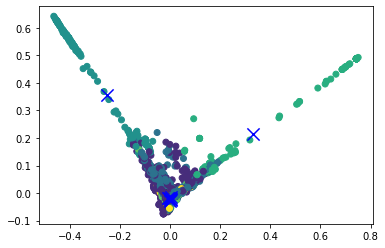

In [155]:
cls = MiniBatchKMeans(n_clusters=9, random_state=0)
cls.fit(features)

pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

100%|██████████| 10/10 [00:01<00:00,  7.92it/s]


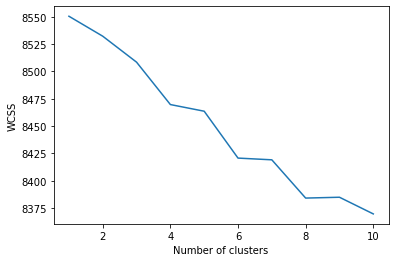

In [151]:
for i in tqdm(range(1, 11)): 
    kmeans = MiniBatchKMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(features) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') 
plt.show()

We run the previously defined function to obtain the silhouette scores, silhouette plots, and clustering distributions.

  0%|          | 0/7 [00:00<?, ?it/s]

Number of clusters = 3 Average silhouette score is found to be : 0.5654479697948316


 14%|█▍        | 1/7 [00:02<00:15,  2.64s/it]

Number of clusters = 4 Average silhouette score is found to be : 0.5401828464212998


 29%|██▊       | 2/7 [00:05<00:13,  2.64s/it]

Number of clusters = 5 Average silhouette score is found to be : 0.5645609770145004


 43%|████▎     | 3/7 [00:07<00:10,  2.65s/it]

Number of clusters = 6 Average silhouette score is found to be : 0.5170534291834272


 57%|█████▋    | 4/7 [00:10<00:07,  2.66s/it]

Number of clusters = 7 Average silhouette score is found to be : 0.4701019213421606


 71%|███████▏  | 5/7 [00:13<00:05,  2.66s/it]

Number of clusters = 8 Average silhouette score is found to be : 0.4638846222760304


 86%|████████▌ | 6/7 [00:15<00:02,  2.65s/it]

Number of clusters = 9 Average silhouette score is found to be : 0.4745084870383514


100%|██████████| 7/7 [00:18<00:00,  2.64s/it]


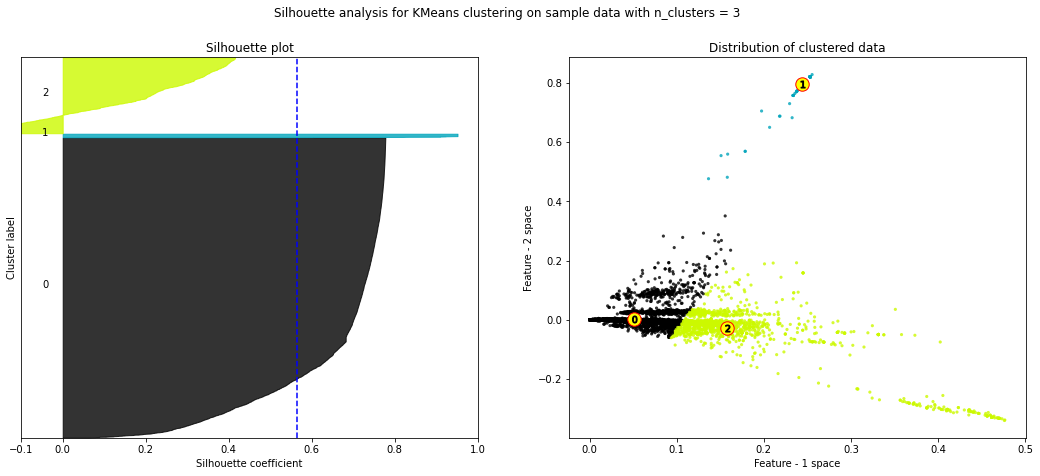

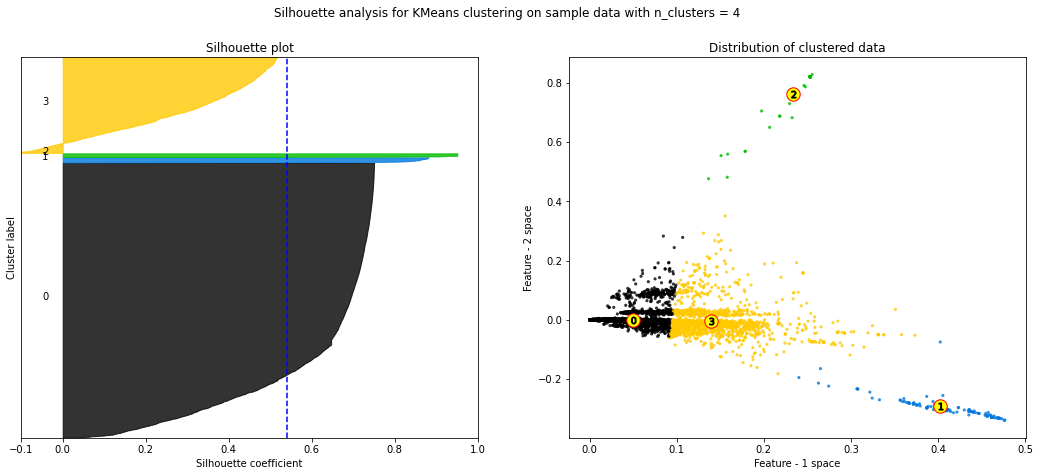

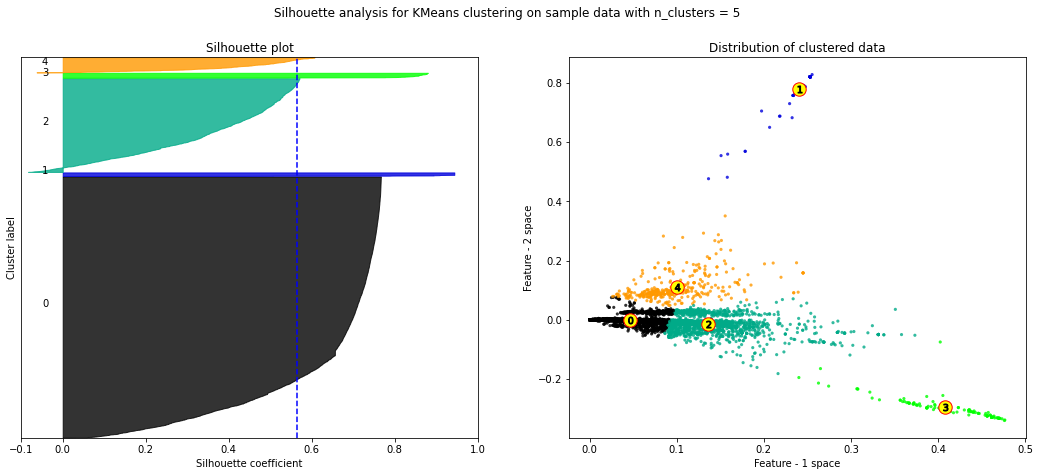

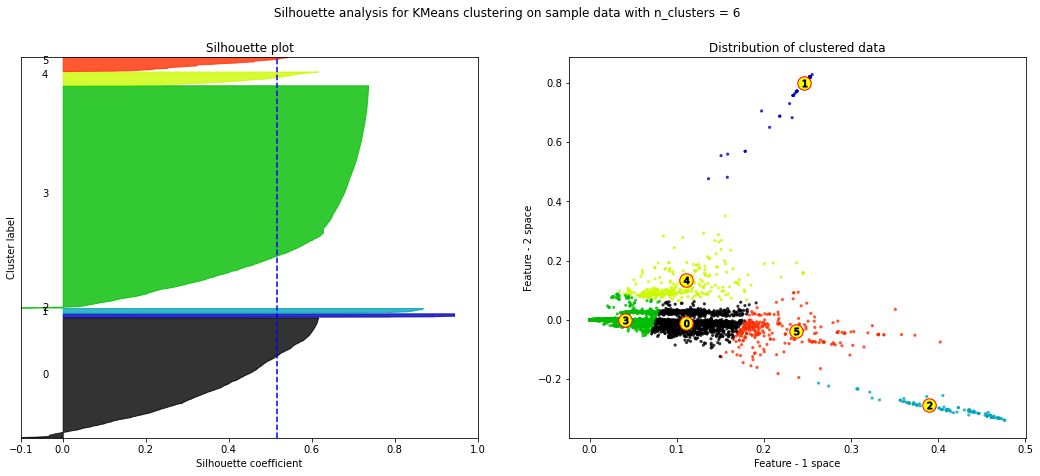

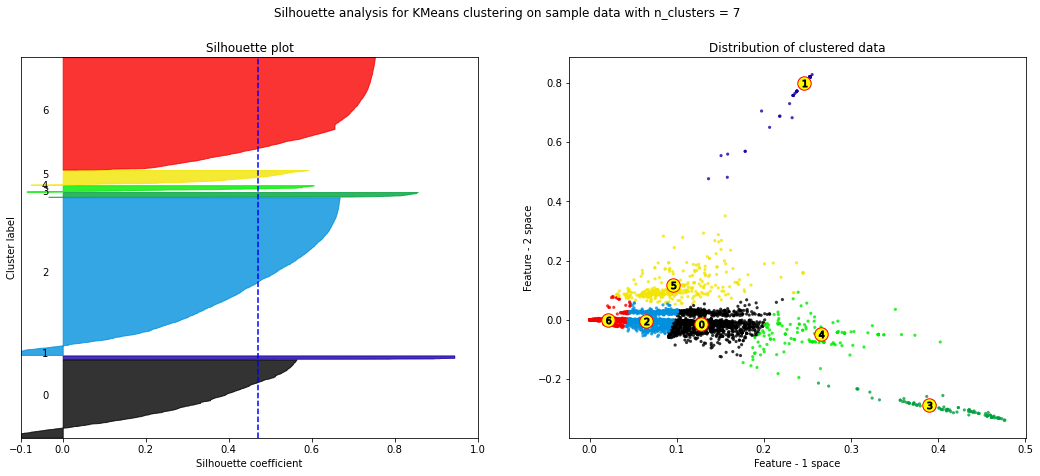

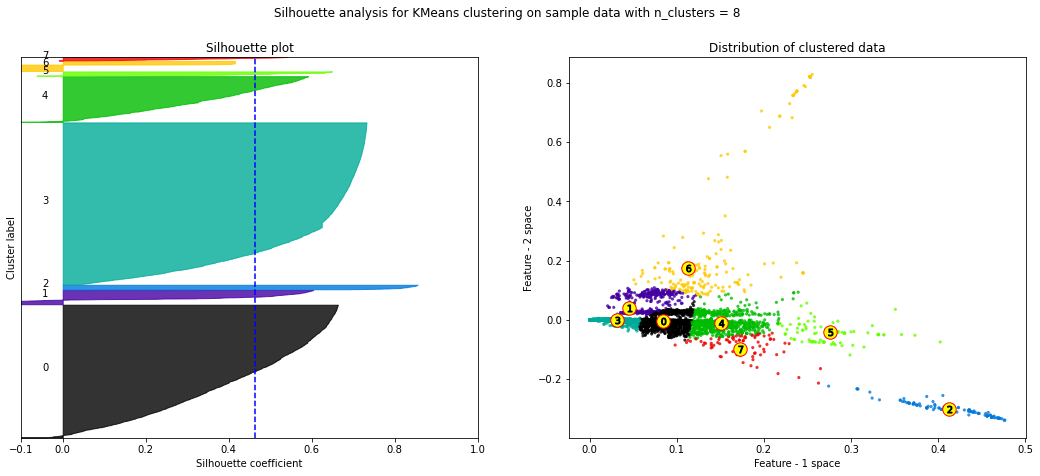

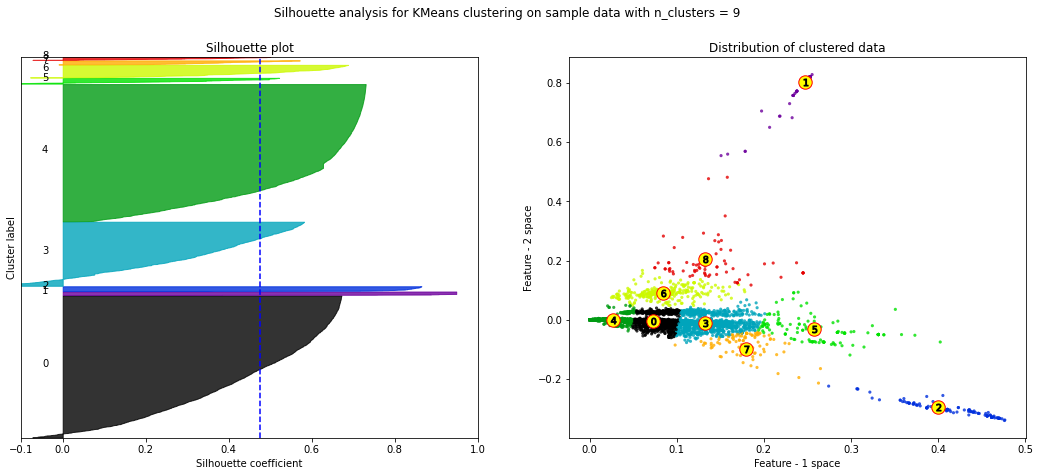

In [150]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.decomposition import TruncatedSVD  
plot_silhouette(tweets_df_mod)

We can now assign the obtained k-means labels to the tweets dataset. This will facilitate further analysis.

In [105]:
tweets_df_mod['kmeans_labels'] = cls.labels_
tweets_df_mod

tweet_filtered  \
0     PramilaJayapal: We've seen this movie before.R...   
1     GarrettHaake: Just wrapped an interview w/ @Se...   
2     ezralevin: Spoiler alert: you're never getting...   
3     JamaalBowmanNY: If what I'm reading is true, I...   
4     PalmerReport: To be clear, once the republican...   
...                                                 ...   
8606  I am hope that this spending bill will be cutt...   
8607  b@JordanChariton @JoeBiden He doesn't want an ...   
8608  @SMcCallum93 @Mick241602 @pritipatel You plain...   
8609  @NGrossman81 He wants an infrastructure bill, ...   
8610  Guess who was on top of the infrastructure Bil...   

                                   description_filtered  \
0     English Teacher to the Stars (well... sort of....   
1     My husband and I are retired and enjoy spendin...   
2     #Chiefs_Champs  #JJJHawk  #ForeverRoyalLiberal...   
3     b(he/him/his) Dad/Archivist with opinions on m...   
4                                           Being me x'   
...                                                 ...   
8606  The real business person of all businesses, no...   
8607                              Opinions are my own.'   
8608  British Jew. Woman. Artist. Mother. Zionist. A...   
8609  One hard-nosed political commentator. Words in...   
8610  bGM skilled retiree/Natural Health-UAW strong-...   

                                     preprocessed_tweet  \
0     pramilajayapal weve seen this movie beforerepu...   
1     garretthaake just wrapped an interview w senjo...   
2     ezralevin spoiler alert youre never getting 10...   
3     jamaalbowmanny if what im reading is true i wo...   
4     palmerreport to be clear once the republicans ...   
...                                                 ...   
8606  i am hope that this spending bill will be cutt...   
8607  bjordanchariton joebiden he doesnt want an inf...   
8608  smccallum93 mick241602 pritipatel you plainly ...   
8609  ngrossman81 he wants an infrastructure bill so no   
8610  guess who was on top of the infrastructure bil...   

                               preprocessed_description  kmeans_labels  
0     english teacher to the stars well sort of publ...              3  
1     my husband and i are retired and enjoy spendin...              1  
2     chiefschamps  jjjhawk  foreverroyalliberal ath...              1  
3     bhehimhis dadarchivist with opinions on many t...              3  
4                                            being me x              1  
...                                                 ...            ...  
8606  the real business person of all businesses nob...              3  
8607                                opinions are my own              1  
8608  british jew woman artist mother zionist a drea...              3  
8609  one hardnosed political commentator words in a...              1  
8610  bgm skilled retireenatural healthuaw strongcat...              1  

[8611 rows x 5 columns]

# Sentiment Analysis

For sentiment analysis, we use the NLTK Vader package. <b>The code here is a modified version of the original Piper Gradient SME typology clustering example.</b> We return various lists including the tweet_list, positive_list, negative_list, neutral_list, and list of sentiments in proper order. A few print statements have been added to the original function for better understadability. 

In [172]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob


def sentiment_analysis(df, col = 'preprocessed_tweet', verbose = True):
  num_tweets = len(df.index)

  def percentage(part,whole):
    return 100 * float(part)/float(whole)

  positive = 0
  negative = 0
  neutral = 0
  polarity = 0
  tweet_list = []
  neutral_list = []
  negative_list = []
  positive_list = []
  sent_list = []
  for index, tweet in df.iterrows():
  
    tweet_list.append(tweet[col])
    analysis = TextBlob(tweet[col])
    score = SentimentIntensityAnalyzer().polarity_scores(tweet[col])
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
      negative_list.append(tweet[col])
      negative += 1
      sent_list.append("Negative")
    elif pos > neg:
      positive_list.append(tweet[col])
      positive += 1
      sent_list.append("Positive")
    elif pos == neg:
      neutral_list.append(tweet[col])
      neutral += 1
      sent_list.append("Neutral")

  positive = percentage(positive, num_tweets)
  negative = percentage(negative, num_tweets)
  neutral = percentage(neutral, num_tweets)
  polarity = percentage(polarity, num_tweets)
  positive = format(positive, '.1f')
  negative = format(negative, '.1f')
  neutral = format(neutral, '.1f')

  if (verbose == True):
    print("Total Tweets: ",len(tweet_list))
    print("positive number: ",len(positive_list))
    print("negative number: ", len(negative_list))
    print("neutral number: ",len(neutral_list))
    print("Positive Percentage: ", positive)
    print("Negative Percentag : ", negative)
    print("Neutral Percentage : ", neutral)
 


  return (tweet_list, positive_list, negative_list, neutral_list, sent_list)

# Testing the Clusters for Sentiment Unifoormity

The following block runs the hypothesis test discussed in the final report and presentation.

Null Hypothesis: Clustering is capable of capturing political nuances in the form of sentiments. Thus, clusters should be reasonably uniform in their sentiment. The threshold can be defined by the user. Here, the threshold is set at 75% positivity.

Alternate Hypothesis: Clustering is incapable of forming clusters that have uniform sentiments at the given threshold.

Note: The function has not been run since it prints out too many statements, making the notebook very long. The function can be called by setting the verbose flag to false. Since sampling is involved, this function can take up to 1 hour to run completely. Uncomment the last line to run the function.

In [176]:
def hypothesis_test(test_df, col = 'preprocessed_tweet', threshold = 75):

    pos_score_list = []

    for i in tqdm(range(50)):
        test_df.sample(n = 100)
        res = sentiment_analysis(test_df, col, verbose = False)
        # Percentage of positive tweets is computed and appended to a list
        pos_score_list.append(len(res[1])*100/(len(res[0])))
    
    std = 5
    z = (np.mean(pos_score_list) - threshold) / ((std)/np.sqrt(len(test_df))) 
    print("Test statistic value = {}".format(z))

    if z < -1.96:
        print("Null rejected at 0.05 level")

    else:
        print("Failed to reject the null at the 0.05 level")

print("Uncomment to run")
# hypothesis_test(tweets_df_mod)

Uncomment to run


# Evaluation using Piper SME typology labels

Although labeling is not a part of this challenge, we can use this typology function defined in the Piper Gradient notebook to do some preliminary evaluation of cluster purity. I have added more terms to each of the lists based on my exploration of the data.

In [107]:
# First, let's establish the Typology dictionary
typology_dict = {'Fringe Left' : -3, 'Progressive' : -2, 'Democrat' : -1, 'Centrist' : 0, 'Libertarian' : 1, 'Republican' : 2, 'Trump-Republican' : 2.5, 'Fringe Right' : 3}

def label_typology (row):
   if pd.isna(row['preprocessed_description']):
     return None
   if any(ele in row['preprocessed_description'] for ele in ['antifa', 'anarchist', 'burnitdown', 'acab']):
      return -3
   if any(ele in row['preprocessed_description'] for ele in ['progressive', 'defund the police', 'patriarchy', 'healthcare','defundthepolice', 'eattherich','anti-fascist', 'bernie', 'gun reform', 'gun reforms']):
      return -2
   if any(ele in row['preprocessed_description'] for ele in ['democrat','liberal', 'blue', 'feminist', 'prochoice', 'leftist','pro-choice', 'resistance', 'bidenharris', 'anti-trump', 'atheist', 'biden', 'harris']):
      return -1
   if any(ele in row['preprocessed_description'] for ele in ['independent','centrist','moderate']):
      return 0
   if any(ele in row['preprocessed_description'] for ele in ['libertarian', 'randpaul', 'freemarket', 'free market', 'rand paul']):
      return 1
   if any(ele in row['preprocessed_description'] for ele in ['republican','prolife','pro-life', 'nra', '2a', 'red']):
      return 2
   if any(ele in row['preprocessed_description'] for ele in ['maga', 'kag', 'americafirst', 'china', 'america 1st', 'parler', 'build a wall', 'trump2024','globalism', 'fakenews', 'fake news', 'stopthesteal', 'steal']):
      return 2.5
   if any(ele in row['preprocessed_description'] for ele in ['alex jones', 'alexjones', 'wlm','white lives', '#whitelives', 'infowars', 'evangelical','sjw','jesus']):
      return 3
   return None

# tweets_df_mod['tweet_category'] = tweets_df['preprocessed_description'].str.lower()
tweets_df_mod['tweet_category'] = tweets_df_mod.apply (lambda row: label_typology(row), axis=1)

# Visual Representations of Clusters Through Word Clouds

The function below can be used to plot word clouds. These are visual representations of the most commonly occurring terms within a cluster of tweets. We can alter the color, dimensions, and font by modifying the word cloud function. It is important to note that the word cloud may not encapsulate all the information required for labeling a cluster. Instead, much like sentiment analysis, it can be used as a guide for labeling and evaluation.

In [108]:

from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(df, col, filter):
    comment_words = ''
    stopwords = set(STOPWORDS)

    for val in df[filter][col]:

        val = str(val)

        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
                    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Since much of the analysis uses pie charts to depict findings, the following function is re-used throughout the notebook. This is a fairly simple function that uses the Matplotlib library to plot charts. We begin by plotting the distribution of tweets within clusters after the k-means algorithm has finished running.

100%|██████████| 9/9 [00:00<?, ?it/s]

Number of elements in cluster =  8611
Plotting...


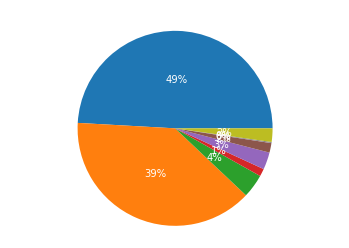

In [109]:
def plot_pie(col, df = tweets_df_mod):

    labels = []
    sizes = []

    for x, y in tqdm(Counter(df[col].to_list()).items()):
        labels.append(x)
        sizes.append(y)
    print("Number of elements in cluster = ", sum(sizes))
    print("Plotting...")
    # Plot
    plt.pie(sizes, labels=labels, textprops=dict(color="w"), autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
    
    plt.axis('equal')
    plt.show()

plot_pie('kmeans_labels')

We then use the NLTK Vader lexicon to get the sentiment analysis results for each cluster of tweets. The information displayed post sentiment analysis gives us the number of positive, negative, and neutral tweets, as well as their corresponding percentages. This is carried out for all 9 clusters.

In [173]:
k_list = []

nltk.download('vader_lexicon')
for ele in tqdm(set(tweets_df_mod['kmeans_labels'].to_list())):
    filt = tweets_df_mod['kmeans_labels'] == ele
    print("Tweet label : " + str(ele))
    k = sentiment_analysis(tweets_df_mod[filt])
    k_list.append(k)
print("##############################################")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nsbha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
  0%|          | 0/9 [00:00<?, ?it/s]

Tweet label : 0


 11%|█         | 1/9 [00:01<00:13,  1.64s/it]

Total Tweets:  246
positive number:  75
negative number:  71
neutral number:  100
Positive Percentage:  30.5
Negative Percentag :  28.9
Neutral Percentage :  40.7
Tweet label : 1


 22%|██▏       | 2/9 [00:23<00:54,  7.84s/it]

Total Tweets:  3345
positive number:  1288
negative number:  796
neutral number:  1261
Positive Percentage:  38.5
Negative Percentag :  23.8
Neutral Percentage :  37.7
Tweet label : 2
Total Tweets:  2
positive number:  2
negative number:  0
neutral number:  0
Positive Percentage:  100.0
Negative Percentag :  0.0
Neutral Percentage :  0.0
Tweet label : 3


 44%|████▍     | 4/9 [00:49<00:46,  9.33s/it]

Total Tweets:  4229
positive number:  1535
negative number:  1347
neutral number:  1347
Positive Percentage:  36.3
Negative Percentag :  31.9
Neutral Percentage :  31.9
Tweet label : 4


 56%|█████▌    | 5/9 [00:50<00:27,  6.92s/it]

Total Tweets:  193
positive number:  122
negative number:  9
neutral number:  62
Positive Percentage:  63.2
Negative Percentag :  4.7
Neutral Percentage :  32.1
Tweet label : 5


 67%|██████▋   | 6/9 [00:51<00:15,  5.10s/it]

Total Tweets:  136
positive number:  88
negative number:  11
neutral number:  37
Positive Percentage:  64.7
Negative Percentag :  8.1
Neutral Percentage :  27.2
Tweet label : 6


 89%|████████▉ | 8/9 [00:53<00:02,  2.96s/it]

Total Tweets:  337
positive number:  138
negative number:  92
neutral number:  107
Positive Percentage:  40.9
Negative Percentag :  27.3
Neutral Percentage :  31.8
Tweet label : 7
Total Tweets:  14
positive number:  0
negative number:  0
neutral number:  14
Positive Percentage:  0.0
Negative Percentag :  0.0
Neutral Percentage :  100.0
Tweet label : 8


100%|██████████| 9/9 [00:54<00:00,  6.06s/it]

Total Tweets:  109
positive number:  35
negative number:  38
neutral number:  36
Positive Percentage:  32.1
Negative Percentag :  34.9
Neutral Percentage :  33.0
##############################################


Since the 5th return value in the tuple is the actual list of sentiments, we run the entire sentiment analysis on all the tweets and add a new column for the sentiment by assigning it to index [4] of the sentiment analysis return value.

In [111]:
tweets_df_mod['Sentiment'] = sentiment_analysis(tweets_df_mod)[4]
tweets_df_mod

Total Tweets:  8611
positive number:  3283
negative number:  2364
neutral number:  2964
Positive Percentage:  38.1
Negative Percentag :  27.5
Neutral Percentage :  34.4


tweet_filtered  \
0     PramilaJayapal: We've seen this movie before.R...   
1     GarrettHaake: Just wrapped an interview w/ @Se...   
2     ezralevin: Spoiler alert: you're never getting...   
3     JamaalBowmanNY: If what I'm reading is true, I...   
4     PalmerReport: To be clear, once the republican...   
...                                                 ...   
8606  I am hope that this spending bill will be cutt...   
8607  b@JordanChariton @JoeBiden He doesn't want an ...   
8608  @SMcCallum93 @Mick241602 @pritipatel You plain...   
8609  @NGrossman81 He wants an infrastructure bill, ...   
8610  Guess who was on top of the infrastructure Bil...   

                                   description_filtered  \
0     English Teacher to the Stars (well... sort of....   
1     My husband and I are retired and enjoy spendin...   
2     #Chiefs_Champs  #JJJHawk  #ForeverRoyalLiberal...   
3     b(he/him/his) Dad/Archivist with opinions on m...   
4                                           Being me x'   
...                                                 ...   
8606  The real business person of all businesses, no...   
8607                              Opinions are my own.'   
8608  British Jew. Woman. Artist. Mother. Zionist. A...   
8609  One hard-nosed political commentator. Words in...   
8610  bGM skilled retiree/Natural Health-UAW strong-...   

                                     preprocessed_tweet  \
0     pramilajayapal weve seen this movie beforerepu...   
1     garretthaake just wrapped an interview w senjo...   
2     ezralevin spoiler alert youre never getting 10...   
3     jamaalbowmanny if what im reading is true i wo...   
4     palmerreport to be clear once the republicans ...   
...                                                 ...   
8606  i am hope that this spending bill will be cutt...   
8607  bjordanchariton joebiden he doesnt want an inf...   
8608  smccallum93 mick241602 pritipatel you plainly ...   
8609  ngrossman81 he wants an infrastructure bill so no   
8610  guess who was on top of the infrastructure bil...   

                               preprocessed_description  kmeans_labels  \
0     english teacher to the stars well sort of publ...              3   
1     my husband and i are retired and enjoy spendin...              1   
2     chiefschamps  jjjhawk  foreverroyalliberal ath...              1   
3     bhehimhis dadarchivist with opinions on many t...              3   
4                                            being me x              1   
...                                                 ...            ...   
8606  the real business person of all businesses nob...              3   
8607                                opinions are my own              1   
8608  british jew woman artist mother zionist a drea...              3   
8609  one hardnosed political commentator words in a...              1   
8610  bgm skilled retireenatural healthuaw strongcat...              1   

      tweet_category Sentiment  
0                NaN   Neutral  
1               -1.0  Negative  
2               -1.0  Positive  
3                NaN  Positive  
4                NaN  Positive  
...              ...       ...  
8606             NaN  Negative  
8607             NaN  Negative  
8608             NaN   Neutral  
8609             NaN  Negative  
8610            -1.0  Negative  

[8611 rows x 7 columns]

As an experiment, we classify Tweets into 'democrat' and 'right wing'. We already know there is an inherent bias, and the '-1' category is over-represented in the dataset. To understand the extent of this data bias, we perform a sentiment analysis on just the '-1' category and compare it to a sentiment analysis of all labels > 0. The results are shown below.

100%|██████████| 8/8 [00:00<00:00, 7981.55it/s]

Democratic Tweets
Number of elements in cluster =  1040
Plotting...


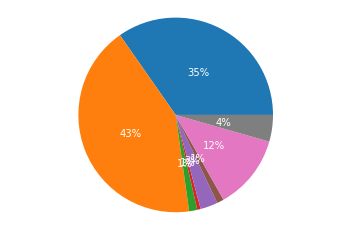

Total Tweets:  1040
positive number:  440
negative number:  302
neutral number:  298
Positive Percentage:  42.3
Negative Percentag :  29.0
Neutral Percentage :  28.7


In [112]:
tweets_democrat = tweets_df_mod.copy()
tweets_democrat = tweets_democrat[tweets_democrat['tweet_category'] == -1]
print("Democratic Tweets")
plot_pie('kmeans_labels', tweets_democrat)
dem_sentiment = sentiment_analysis(tweets_democrat, col = 'preprocessed_tweet')

100%|██████████| 8/8 [00:00<?, ?it/s]

Number of elements in cluster =  682
Plotting...


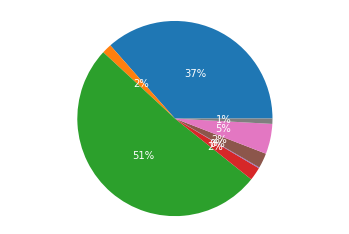

Total Tweets:  682
positive number:  251
negative number:  204
neutral number:  227
Positive Percentage:  36.8
Negative Percentag :  29.9
Neutral Percentage :  33.3


In [113]:
tweets_repub = tweets_df_mod.copy()
tweets_repub = tweets_repub[tweets_repub['tweet_category'] > 0]
plot_pie('kmeans_labels', tweets_repub)
rep_sentiment = sentiment_analysis(tweets_repub, col = 'preprocessed_tweet')

We first remove all 'NaN' values from the tweets dataframe. Then, we plot a pie chart of the tweet categories by sentiment. The first pie chart is for neutral tweets, the second for positive, and the third for negative. There are several positive tweets in the dataset, and 53% of these tweets are made by Democrats in the '-1' category. 

100%|██████████| 8/8 [00:00<00:00, 7900.74it/s]

Number of elements in cluster =  642
Plotting...


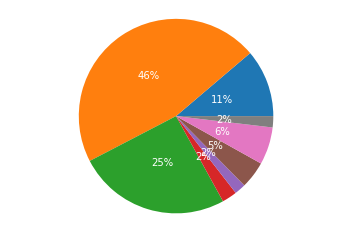

100%|██████████| 8/8 [00:00<?, ?it/s]


Number of elements in cluster =  833
Plotting...


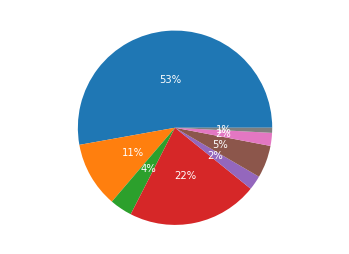

100%|██████████| 8/8 [00:00<?, ?it/s]


Number of elements in cluster =  636
Plotting...


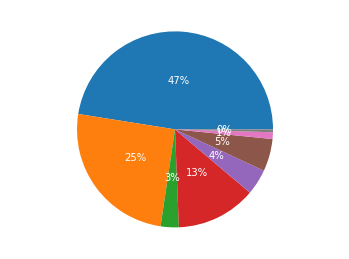

Homogeneity: 0.044
Completeness: 0.039
V-measure: 0.041
Adjusted Rand-Index: -0.019


C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


In [114]:
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]
print("Neutral")
plot_pie('tweet_category', n_df[n_df['Sentiment'] == 'Neutral'])

print("Positive")
plot_pie('tweet_category', n_df[n_df['Sentiment'] == 'Positive'])

print("Negative")
plot_pie('tweet_category', n_df[n_df['Sentiment'] == 'Negative'])

calc_metrics(n_df, 'kmeans_labels', 'tweet_category')

For each cluster, we plot the word cloud and the corresponding distribution of sentiment. This helps us see if there is any overt relationship between the sentiment and the frequently used terms within the cluster. It is worth noticing that some of the word clouds (and by extension, clusters) barely have any representation. However, these are some of the most strongly opinionated clusters.

Cluster number 0


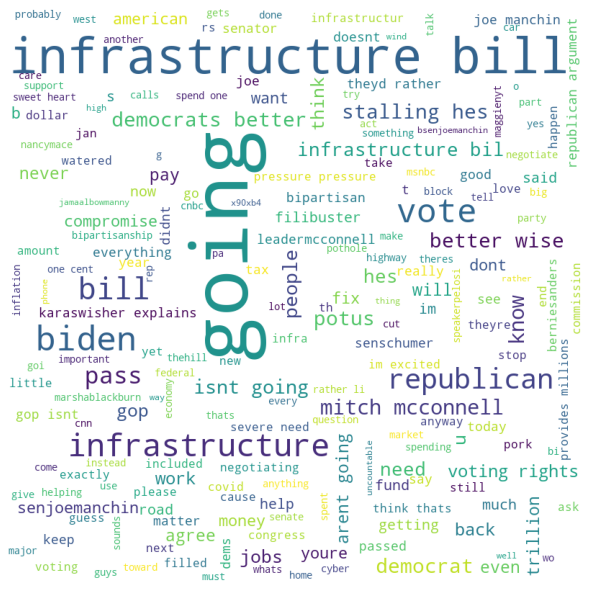

100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


Number of elements in cluster =  246
Plotting...


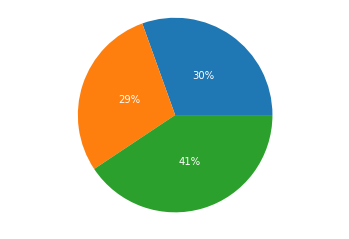

#################################################################################################
Cluster number 1


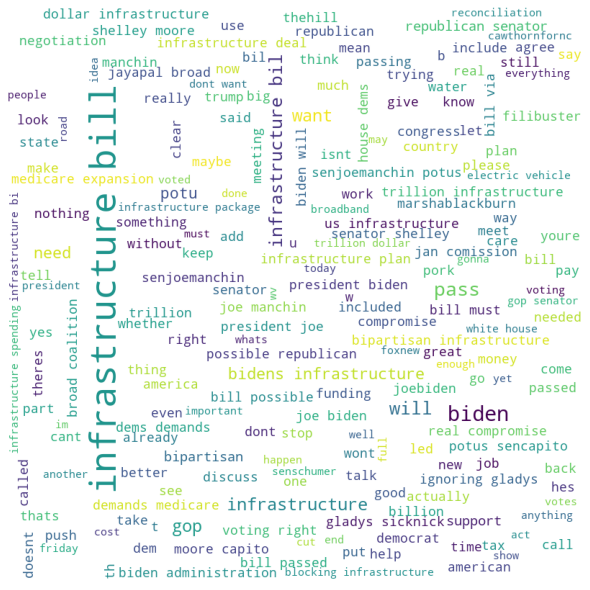

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  3345
Plotting...


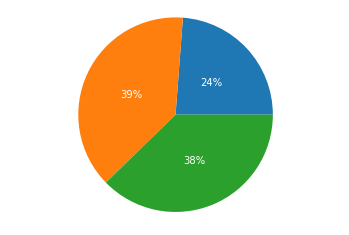

#################################################################################################
Cluster number 2


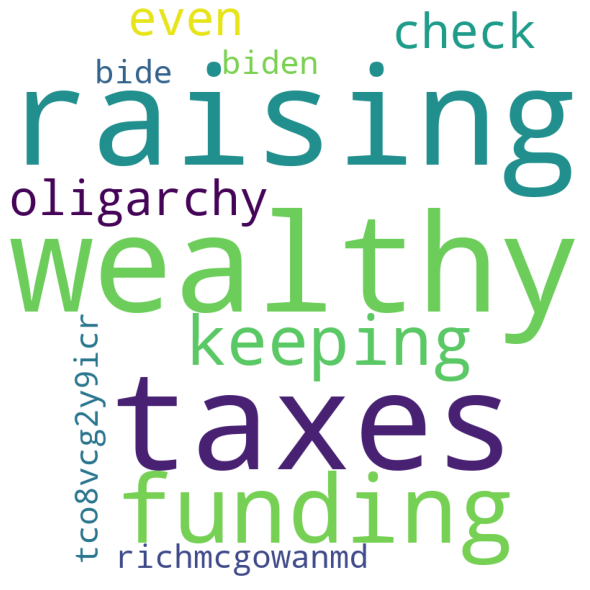

100%|██████████| 1/1 [00:00<?, ?it/s]

Number of elements in cluster =  2
Plotting...


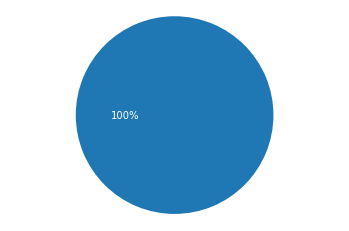

#################################################################################################
Cluster number 3


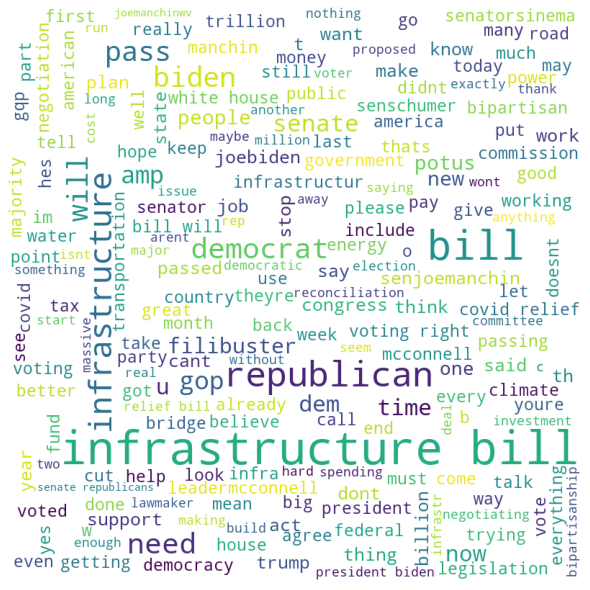

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  4229
Plotting...


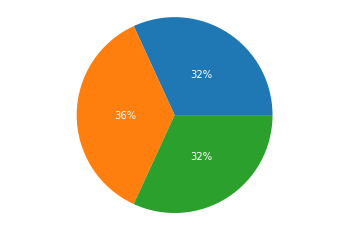

#################################################################################################
Cluster number 4


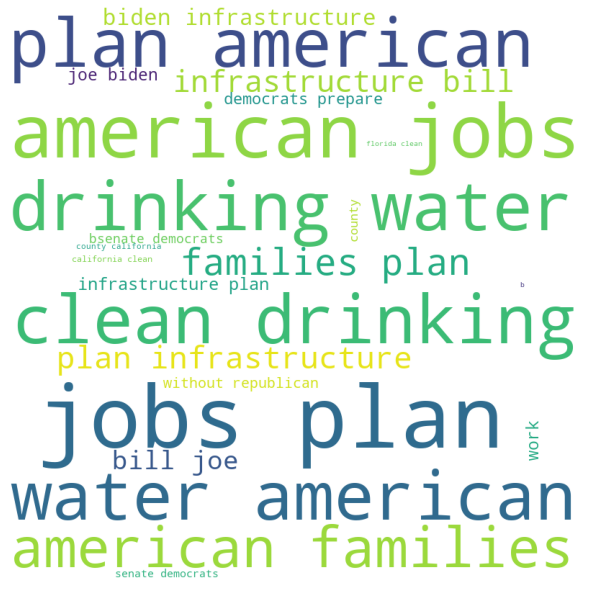

100%|██████████| 3/3 [00:00<00:00, 3000.93it/s]

Number of elements in cluster =  193
Plotting...


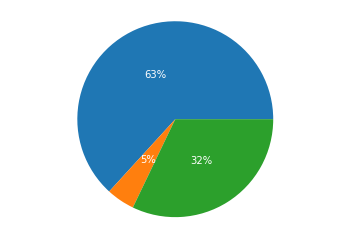

#################################################################################################
Cluster number 5


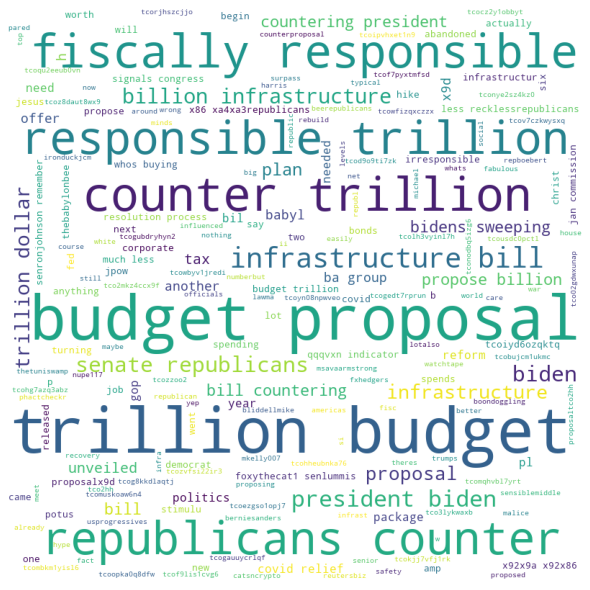

100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]

Number of elements in cluster =  136
Plotting...


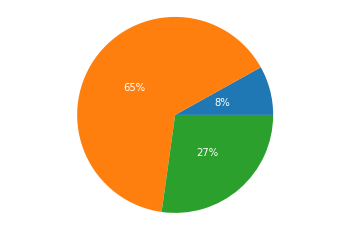

#################################################################################################
Cluster number 6


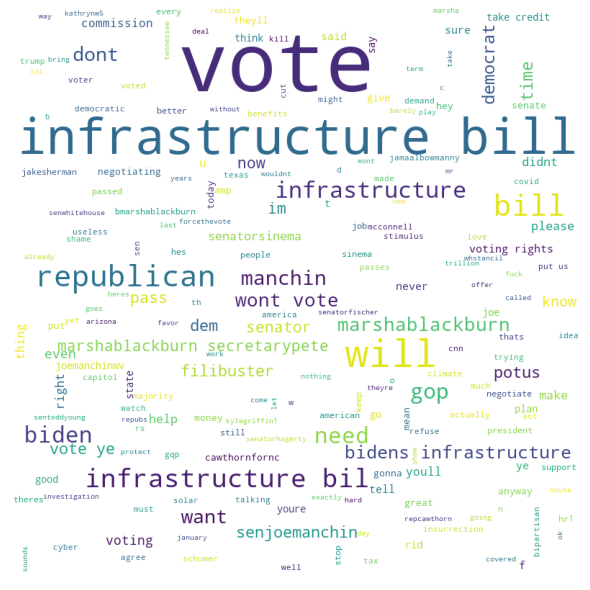

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  337
Plotting...


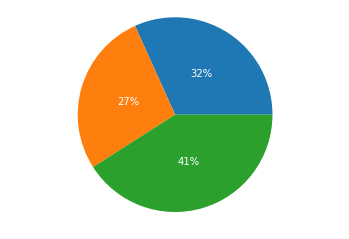

#################################################################################################
Cluster number 7


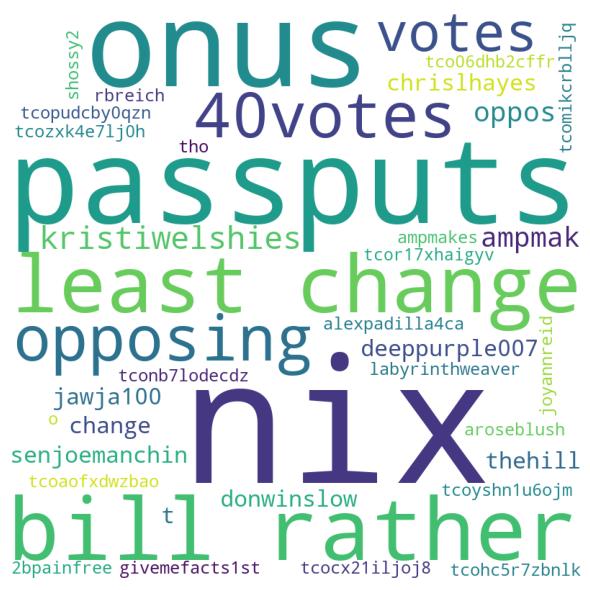

100%|██████████| 1/1 [00:00<?, ?it/s]

Number of elements in cluster =  14
Plotting...


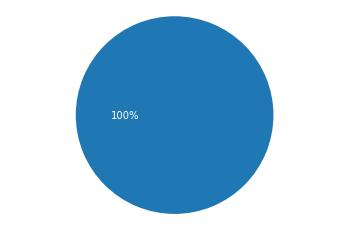

#################################################################################################
Cluster number 8


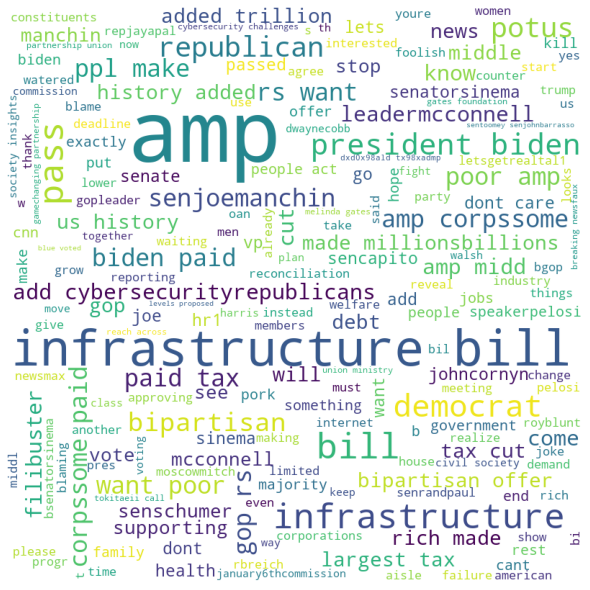

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  109
Plotting...


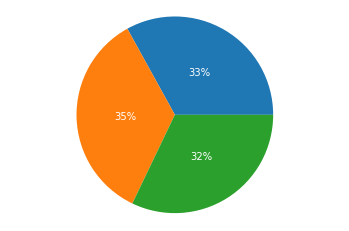

#################################################################################################


In [171]:
for i in range(0,9):
    print("Cluster number {}".format(i))
    plot_wordcloud(df = tweets_df_mod, col = 'preprocessed_tweet', filter = tweets_df_mod['kmeans_labels'] == i)
    plot_pie('Sentiment', tweets_df_mod[tweets_df_mod['kmeans_labels'] == i])
    print("#################################################################################################")

# Spectral Clustering (Graph-Based Approach)

Spectral cluster is a graph-based clustering algorithm that uses similarity matrices to perform clustering after dimensionality reduction. The TF-IDF score acts as a proxy for the similarity metric between words within the graph. Given the similarity matrix, we compute the corresponding Laplacian matrix (L) by subtracting it from a diagonal matrix (D). We then take the first ‘k’ eigenvectors (‘k’ lowest eigenvalues of L). The p’th row of the resulting matrix of the first ‘k’ eigenvectors represents the p’th feature of the node in the graph. Now, the nodes in the graph can be clustered using any distance-based clustering algorithm. In this case, k-means is used alongside Dijkstra’s algorithm to calculate the distance between nodes.


Here, we compare the labels of the k-means clustering and the labels obtained through spectral clustering. The homogeneity score is quite high compared to previous results. This means that the two algorithms might be looking at similar features.

In [159]:
from sklearn.cluster import SpectralClustering

vec = TfidfVectorizer(stop_words="english")
col = "preprocessed_tweet"
vec.fit(tweets_df_mod[col].values)

pca = TruncatedSVD(n_components=2)

features = vec.transform(tweets_df_mod[col].values)
# features = pca.fit_transform(features)

spectral_clustering = SpectralClustering(n_clusters = 9,
    assign_labels='discretize',
    random_state=0, n_components=9).fit(features)
    
print("Homogeneity: %0.3f" % metrics.homogeneity_score(cls.labels_, spectral_clustering.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(cls.labels_, spectral_clustering.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(spectral_clustering.labels_, cls.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(spectral_clustering.labels_, cls.labels_))

Homogeneity: 0.216
Completeness: 0.213
V-measure: 0.215
Adjusted Rand-Index: 0.187


To further compare the two algorithms, we plot pie charts for the distribution of the labels amongst clusters generated by both algorithms. We see that spectral clustering has a higher percentage of the dominant label. However, none of the clusters have single-digit elements unlike batch k-means.

100%|██████████| 9/9 [00:00<?, ?it/s]

Distribution of tweets within clusters
#############################
Spectral Clustering
Number of elements in cluster =  8611
Plotting...


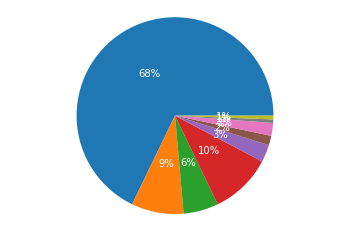

100%|██████████| 9/9 [00:00<?, ?it/s]

############################
K-Means Clustering
Number of elements in cluster =  8611
Plotting...


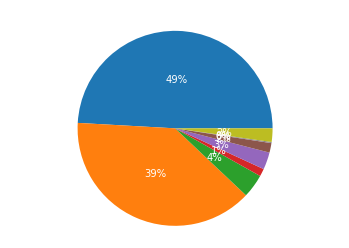

In [160]:
# Plotting cluster labels vs. spectral labels - Distributions
tweets_df_mod['spectral_labels'] = spectral_clustering.labels_
print("Distribution of tweets within clusters")
print("#############################")
print("Spectral Clustering")
plot_pie('spectral_labels')
print("############################")
print("K-Means Clustering")
plot_pie('kmeans_labels')

When we calculate the metrics for the spectral labels and the user description based tweet categories, we see that the homogeneity score is significantly higher. This might mean that spectral clustering is a better tool for the eventual labeling exercise that needs to be carried out.

In [161]:
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]
calc_metrics(n_df, 'spectral_labels', 'tweet_category')

Homogeneity: 0.048
Completeness: 0.044
V-measure: 0.046
Adjusted Rand-Index: -0.017


C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)
C:\Python38\lib\site-packages\sklearn\metrics\cluster\_supervised.py:58: UserWarning: Clustering metrics expects discrete values but received multiclass values for label, and continuous values for target
  warnings.warn(msg, UserWarning)


Finally, we plot the word clouds and sentiment distributions for each of the clusters, similar to the exercise carried out in the batch k-means section above.

Cluster number 0


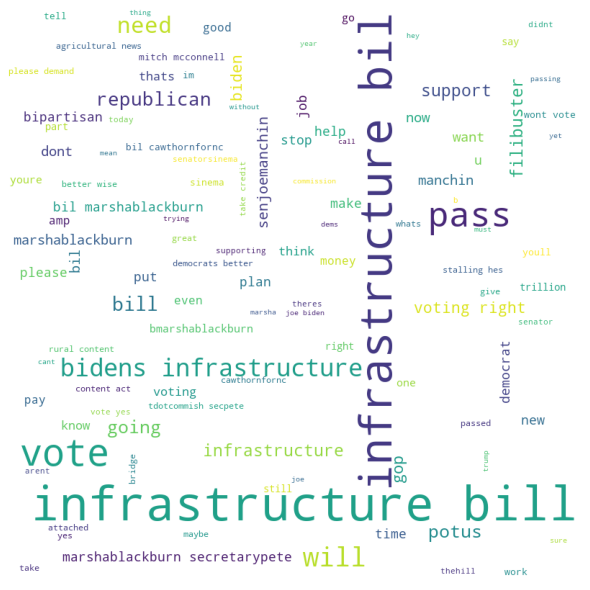

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  739
Plotting...


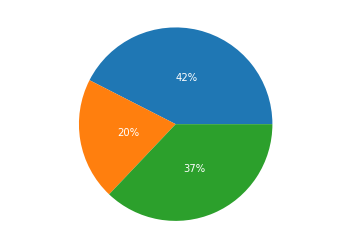

#################################################################################################
Cluster number 1


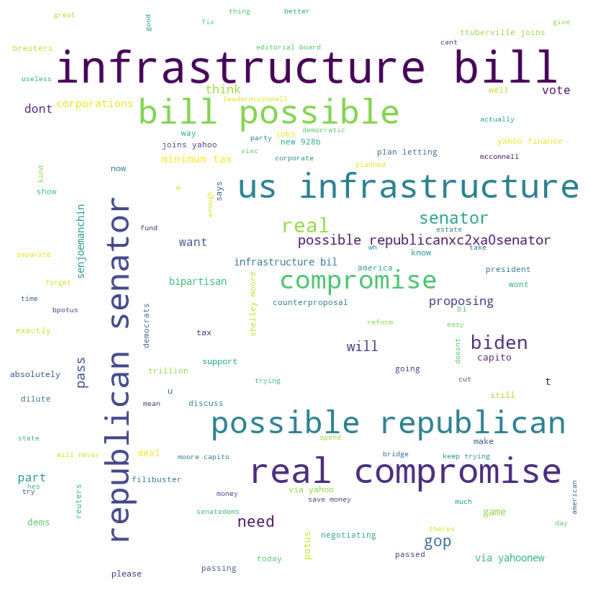

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  247
Plotting...


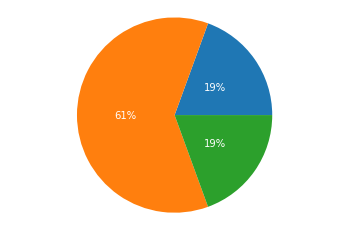

#################################################################################################
Cluster number 2


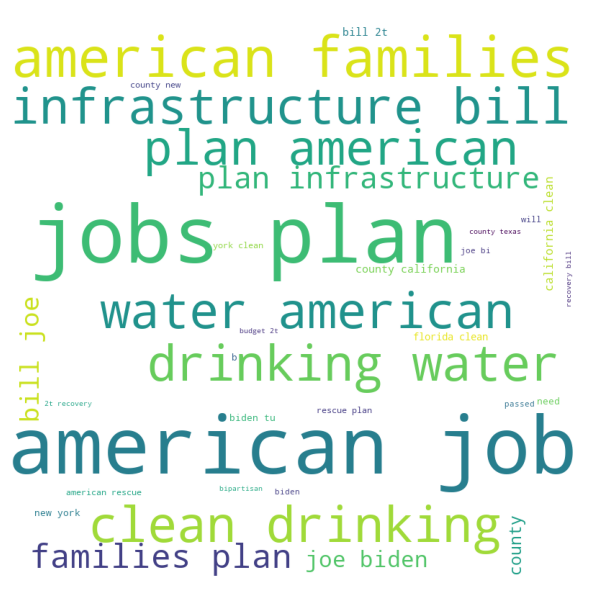

100%|██████████| 3/3 [00:00<00:00, 3009.55it/s]

Number of elements in cluster =  182
Plotting...


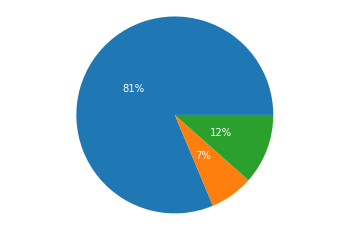

#################################################################################################
Cluster number 3


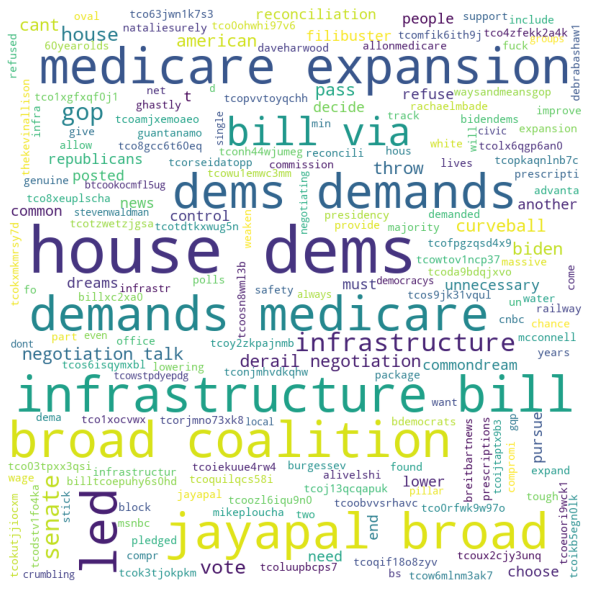

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  53
Plotting...


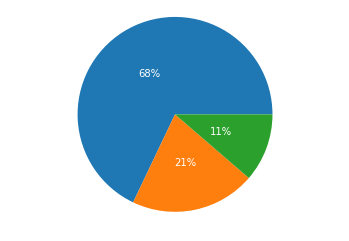

#################################################################################################
Cluster number 4


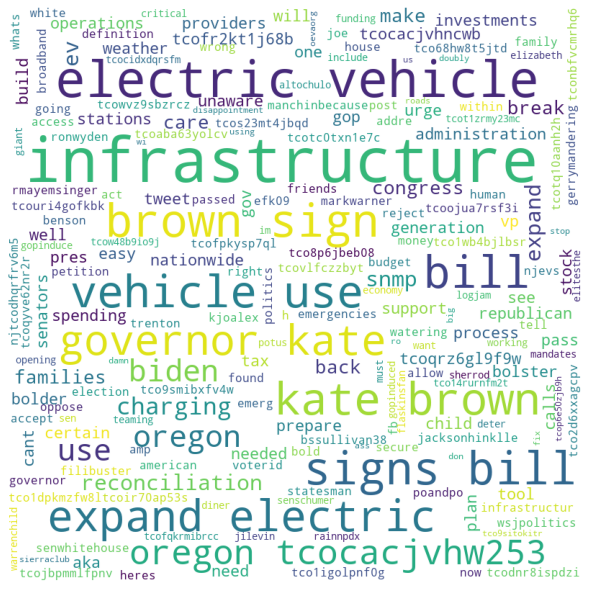

100%|██████████| 3/3 [00:00<00:00, 3003.08it/s]

Number of elements in cluster =  49
Plotting...


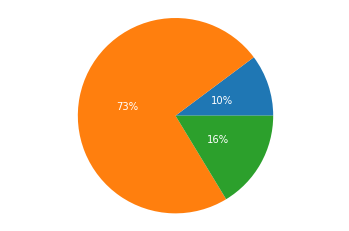

#################################################################################################
Cluster number 5


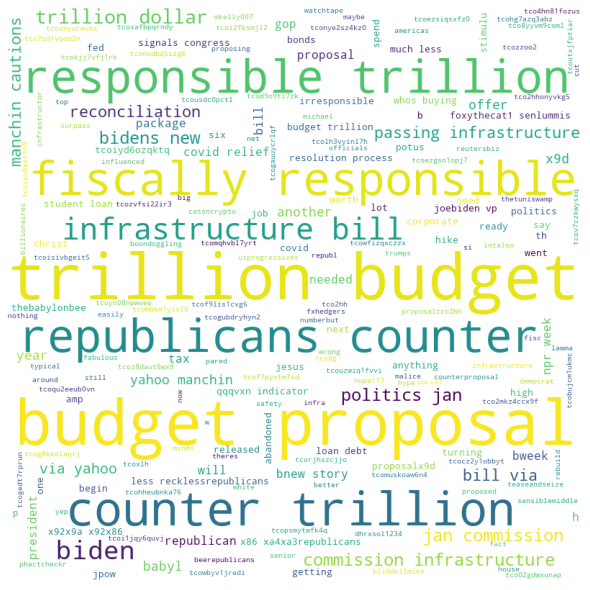

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  133
Plotting...


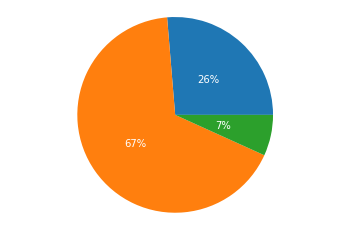

#################################################################################################
Cluster number 6


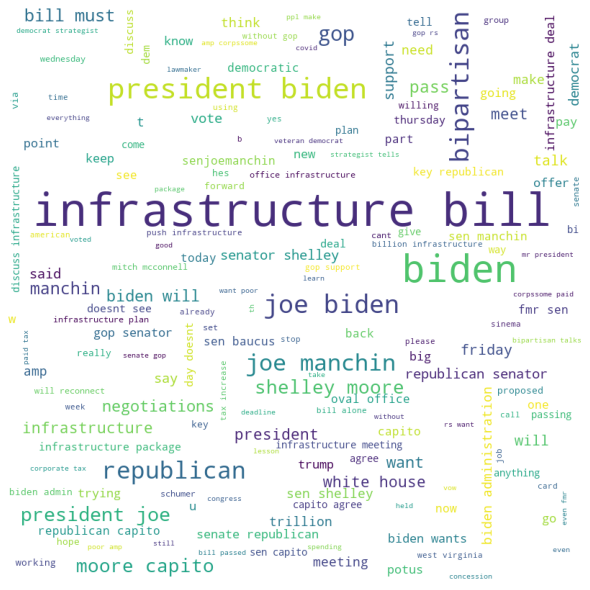

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  873
Plotting...


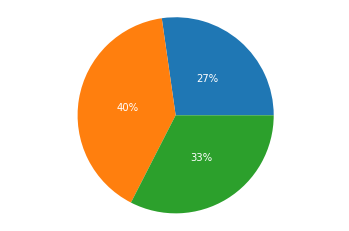

#################################################################################################
Cluster number 7


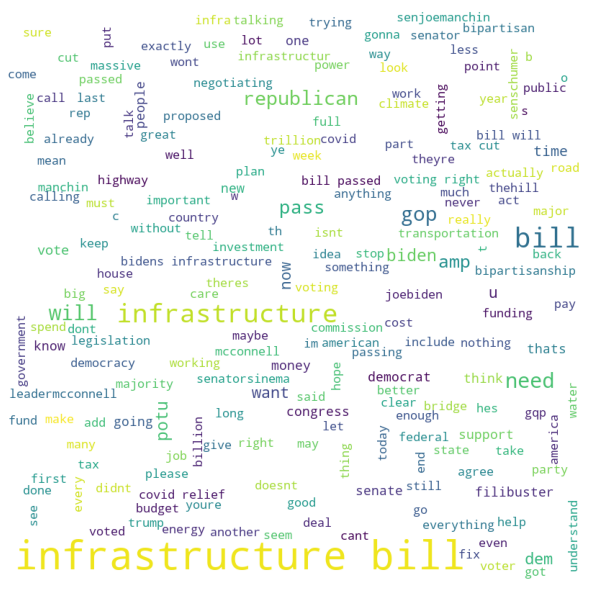

100%|██████████| 3/3 [00:00<?, ?it/s]

Number of elements in cluster =  5840
Plotting...


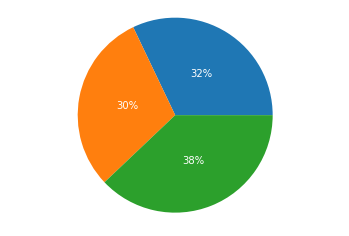

#################################################################################################
Cluster number 8


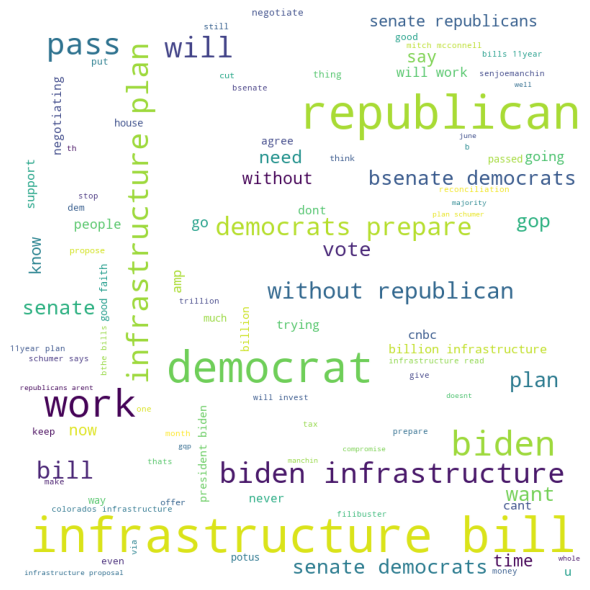

100%|██████████| 3/3 [00:00<00:00, 2955.82it/s]

Number of elements in cluster =  495
Plotting...


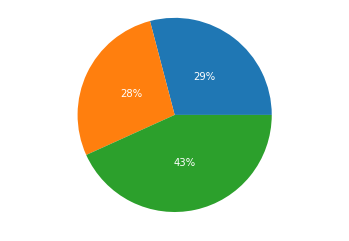

#################################################################################################


In [170]:
for i in range(0,len(set(spectral_clustering.labels_))):
    print("Cluster number {}".format(i))
    plot_wordcloud(df = tweets_df_mod, col = 'preprocessed_tweet', filter = tweets_df_mod['spectral_labels'] == i)
    plot_pie('Sentiment', tweets_df_mod[tweets_df_mod['spectral_labels'] == i])
    print("#################################################################################################")

In [164]:
import math
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]

100%|██████████| 8/8 [00:00<00:00, 8008.22it/s]

Number of elements in cluster =  2111
Plotting...


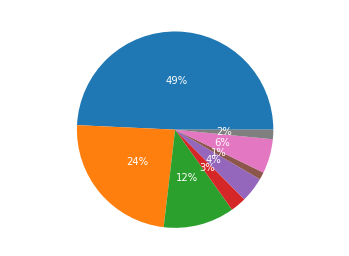

In [165]:
import math
n_df = tweets_df_mod[tweets_df_mod['tweet_category'] > -10]
plot_pie('tweet_category', n_df)

# Brief Analysis of Crowd Sourced Pew Dataset

This is an additional section that incorporates the new crowd sourced pew tweets. We check the metrics for this dataset by comparing it with the assigned labels for the tweets post batch k-means and spectral clustering. We find that the results are quite positive in this case. The homogeneity score is almost 10%, which means that several of the label assignments are quite accurate.

In [166]:
cr_df = pd.read_csv('crowd_sourced_pew_tweets.csv')

print(len(cr_df))
cr_df = cr_df.drop(columns = ['Unnamed: 0', 'created_at', 'id', 'reply_to_id', 'screen_name',
       'coordinates', 'place', 'retweet_count', 'favorite_count', 'lang',
       'source', 'is_quote_status', 'user_id', 'user_loc',
       'verified', 'followers_count', 'friends_count', 'favourites_count',
       'statuses_count', 'listed_count', 'user_created_at'])

cr_df['tweet_filtered'] = clean_text(cr_df.text.to_list())
cr_df['description_filtered'] = clean_text(cr_df.user_description.to_list())
cr_df = cr_df.drop(columns=['user_description', 'text'])
cr_df.reset_index(drop=True, inplace=True)

print(cr_df)
cr_df = preprocess(cr_df, 'tweet_filtered', 'preprocessed_tweet')

# cr_df = preprocess(cr_df, 'description_filtered', 'preprocessed_description')

cr_df

1985
      tweet category  2017 Pew Research Typology  \
0               -2.0                        -3.0   
1                NaN                        -4.0   
2                NaN                         0.0   
3                NaN                        -4.0   
4                NaN                        -4.0   
...              ...                         ...   
1980             NaN                        -4.0   
1981            -1.0                        -2.6   
1982             NaN                        -4.0   
1983             NaN                        -4.0   
1984             NaN                        -4.0   

                                         tweet_filtered  \
0     SenSchumer: This Senate will work with @POTUS ...   
1     EyeOfTheIdol: Fuck Mitch McConnell and the Rep...   
2     WATCH LIVE: Biden to rally support for infrast...   
3     MSNBC: .@SRuhle: According to US News &amp; Wo...   
4     bNBCNews: U.S. Senate overwhelmingly passes $3...   
...             

tweet category  2017 Pew Research Typology  \
0               -2.0                        -3.0   
1                NaN                        -4.0   
2                NaN                         0.0   
3                NaN                        -4.0   
4                NaN                        -4.0   
...              ...                         ...   
1980             NaN                        -4.0   
1981            -1.0                        -2.6   
1982             NaN                        -4.0   
1983             NaN                        -4.0   
1984             NaN                        -4.0   

                                         tweet_filtered  \
0     SenSchumer: This Senate will work with @POTUS ...   
1     EyeOfTheIdol: Fuck Mitch McConnell and the Rep...   
2     WATCH LIVE: Biden to rally support for infrast...   
3     MSNBC: .@SRuhle: According to US News &amp; Wo...   
4     bNBCNews: U.S. Senate overwhelmingly passes $3...   
...                                                 ...   
1980  @tribelaw @waltshaub @tedcruz I keep asking th...   
1981  @tribelaw @waltshaub @tedcruz I bet if Biden's...   
1982  mmpadellan: Republicans are against:- The COVI...   
1983  bBtfsplkJ: @mkraju Which = $189B when the GOP ...   
1984  mmpadellan: Republicans are against:- The COVI...   

                                   description_filtered  \
0     Calming Down class | Parent Success book | Lif...   
1            25 years as a bartender a.k.a. a therapist   
2     Get all the major news that matters to you fro...   
3                                                   nan   
4     Mother•Grandmother•Family's Everything•The Art...   
...                                                 ...   
1980                                                nan   
1981                                                nan   
1982  #ProChoice #Liberal #CoeXisT #HumanityFirst #H...   
1983                                                nan   
1984  Disabled Vet🇺🇸Pain Warrior No Filter.🤬 😈I SNAC...   

                                     preprocessed_tweet  
0     senschumer this senate will work with potus to...  
1     eyeoftheidol fuck mitch mcconnell and the repu...  
2     watch live biden to rally support for infrastr...  
3     msnbc sruhle according to us news amp world re...  
4     bnbcnews us senate overwhelmingly passes 35b b...  
...                                                 ...  
1980  tribelaw waltshaub tedcruz i keep asking the s...  
1981  tribelaw waltshaub tedcruz i bet if bidens inf...  
1982  mmpadellan republicans are against the covid r...  
1983  bbtfsplkj mkraju which  189b when the gop acco...  
1984  mmpadellan republicans are against the covid r...  

[1985 rows x 5 columns]

In [167]:
def kmeans(df, col, n_clusters = 9):
    vec = TfidfVectorizer(stop_words="english")
    vec.fit(df[col].values)
    features = vec.transform(df[col].values)
   

    cls = MiniBatchKMeans(n_clusters, random_state=20)
    cls.fit(features)

    # predict cluster labels for new dataset
    cls.predict(features)

    # to get cluster labels for the dataset used while
    # training the model (used for models that does not
    # support prediction on new dataset).

    print(Counter(cls.labels_))


    return cls

In [168]:
cr_labels = kmeans(cr_df, 'preprocessed_tweet').labels_
cr_df['kmeans_labels_tweets'] = cr_labels

Counter({7: 1302, 8: 173, 6: 119, 1: 89, 5: 69, 3: 69, 0: 67, 2: 53, 4: 44})


In [169]:
cr_df['2017 Pew Research Typology'] = cr_df['2017 Pew Research Typology'].apply(lambda x : round(x, 0))
calc_metrics(cr_df)

Homogeneity: 0.098
Completeness: 0.066
V-measure: 0.079
Adjusted Rand-Index: -0.033
